In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
pruning='0.3'

In [4]:
bud_df = pd.read_csv('/Users/joel/Projects/sep-multi2/opti-bud.csv',names=['e','n','bud_number','size','bud_percentage','mean_budtime'])
net_df = pd.read_csv('/Users/joel/Projects/sep-multi2/opti-net'+pruning+'.csv',header=0)

In [5]:
for c in bud_df.columns:
    bud_df[c] = bud_df[c].astype(float)
for c in net_df.columns:
    net_df[c] = net_df[c].astype(float)

In [6]:
# net_df.head(5)

In [7]:
criticalRegion = bud_df.query('bud_percentage > 0.2 & bud_percentage < 0.8 & e*n < 320')[['e','n']].values.tolist()
criticalNets = pd.DataFrame(columns=net_df.columns)
for c in criticalRegion:
    runNets = net_df[(net_df['Mean Affinity']==c[1]) & (net_df['Ligand Number']==c[0])]
    criticalNets = criticalNets.append(runNets)

In [8]:
bud_df = None
net_df = None

In [9]:
budNets = criticalNets[criticalNets['Mean Budding Time'] > 0.0].groupby(['Mean Affinity','Ligand Number']).mean().reset_index()
nonbudNets = criticalNets[criticalNets['Mean Budding Time'] < 0.0].groupby(['Mean Affinity','Ligand Number']).mean().reset_index()

In [10]:
meanBudNets = criticalNets[criticalNets['Mean Budding Time'] > 0.0].groupby(['Ligand Number']).mean().reset_index()
meanNonbudNets = criticalNets[criticalNets['Mean Budding Time'] < 0.0].groupby(['Ligand Number']).mean().reset_index()

248.54545454545453 200.0 312.0


/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


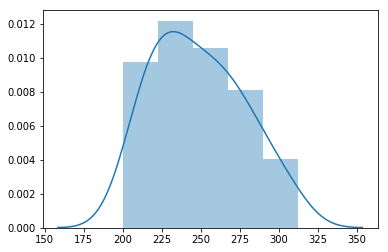

In [11]:
criticalEnergy = map(lambda x: x[0]*x[1],criticalRegion)
ax = sns.distplot(criticalEnergy)
print np.mean(criticalEnergy) , np.min(criticalEnergy), np.max(criticalEnergy)


In [12]:
bins = np.linspace(0, 100, 26)
print bins

digitisedLigandNum = np.digitize(budNets["Ligand Number"], bins)
binnedLigandNum = [budNets["Ligand Number"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]
binnedNonBudLigandNum = [nonbudNets["Ligand Number"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]
binnedBuddingRate = [budNets["Budding Rate"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]

binnedLigandNum = [b for b in binnedLigandNum if not np.isnan(b)]
binnedNonBudLigandNum = [b for b in binnedNonBudLigandNum if not np.isnan(b)]
binnedBuddingRate = [b for b in binnedBuddingRate if not np.isnan(b)]

[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100.]


In [36]:
def buildBinnedPlot(c):
    binnedBudC = [budNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
    binnedBudyErr = [b for b in [np.std(budNets[c][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    binnedBudxErr = [b for b in [np.std(budNets["Ligand Number"][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    binnedBudC = [b for b in binnedBudC if not np.isnan(b)]
    binnedNoBudC = [nonbudNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
    binnedNoBudC = [b for b in binnedNoBudC if not np.isnan(b)]
    binnedNoBudyErr = [b for b in [np.std(nonbudNets[c][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    binnedNoBudxErr = [b for b in [np.std(nonbudNets["Ligand Number"][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    return binnedBudC,binnedBudxErr,binnedBudyErr,binnedNoBudC,binnedNoBudxErr,binnedNoBudyErr

In [100]:
def buildHistPlot(c,n):
    budPop = criticalNets[(criticalNets['Mean Budding Time'] > 0.0)&(criticalNets['Ligand Number']==float(n))][c].values.tolist()
    nonBudPop = criticalNets[(criticalNets['Mean Budding Time'] < 0.0)&(criticalNets['Ligand Number']==float(n))][c].values.tolist()
    return budPop, nonBudPop
    

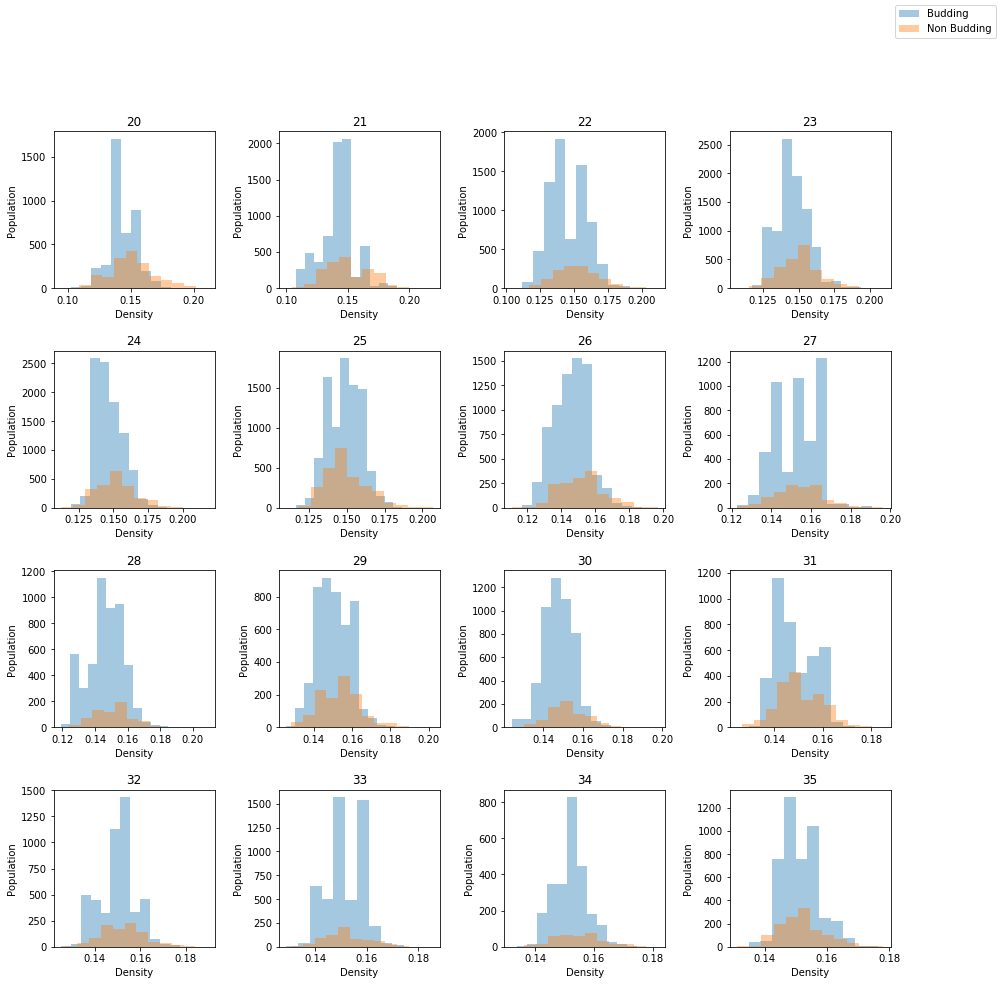

In [143]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
startI = 20
for i in range(startI,startI+16):
    ax = plt.subplot(4, 4, i-startI+1)
    r = buildHistPlot("Density",i)
    ax = sns.distplot(r[0],label="Budding",bins=12,kde=False)
    ax = sns.distplot(r[1],label="Non Budding",bins=12,kde=False)
    ax.set_xlabel("Density")
    ax.set_ylabel("Population")
    ax.set_title(i)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

In [152]:
def bigFig(c,label="NONE"):
    if label=="NONE":
        label = c
    plt.figure(figsize=(12,7.5))
    ax = plt.subplot(111)

    r = [int(np.floor(min(budNets[c])*1000)), int(np.ceil(max(budNets[c])*1000)+1)]
    # for y in range(r[0],r[1]):    
    #     plt.plot(range(r[0],r[1]), [y] * len(range(r[0],r[1])), "--", lw=0.5, color="black", alpha=0.3)

    xr = range(int(np.floor(min(budNets['Ligand Number']))-1), int(np.ceil(max(budNets['Ligand Number']))+2))

    # for y in range(r[0],r[1]):    
    #     plt.plot(xr, [y*0.001] * len(xr) , "--", lw=0.5, color="black", alpha=0.3)    


    r = buildBinnedPlot(c)

    plt.errorbar(binnedLigandNum,r[0],xerr=r[1],yerr=r[2],fmt='o',label="Budding")
    plt.errorbar(binnedNonBudLigandNum,r[3],yerr=r[5],xerr=r[4],fmt='o',label="Non Budding")

    plt.ylabel(label,fontsize=16)
    plt.xlabel("Ligand Number",fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False) 
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()   
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                    labelbottom="on", left="off", right="off", labelleft="on")  
    plt.legend(loc='lower right',fontsize=12,bbox_to_anchor=(0.9, 0.1))
    plt.savefig('/Users/joel/Projects/Figures/eps/'+label+'-LigandNumber.eps', format='eps', dpi=1000)
    plt.savefig('/Users/joel/Projects/Figures/png/'+label+'-LigandNumber.png')

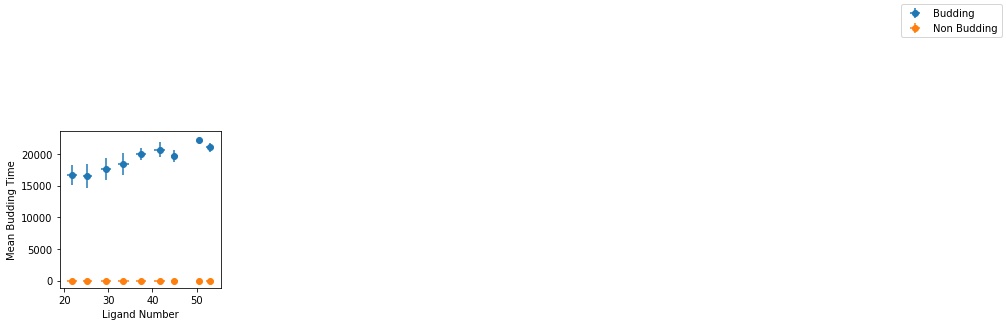

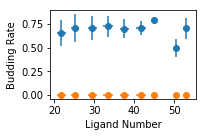

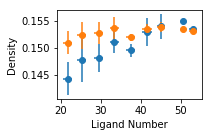

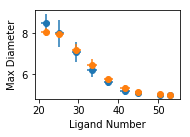

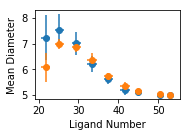

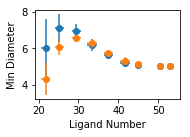

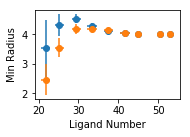

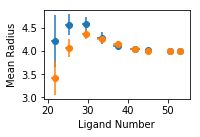

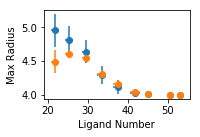

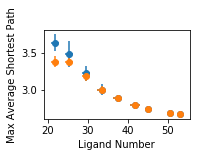

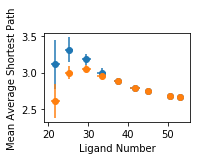

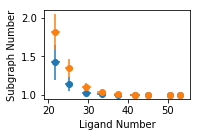

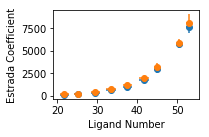

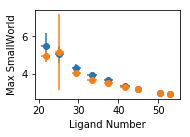

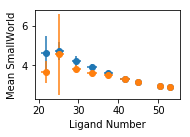

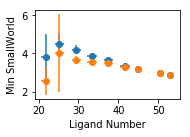

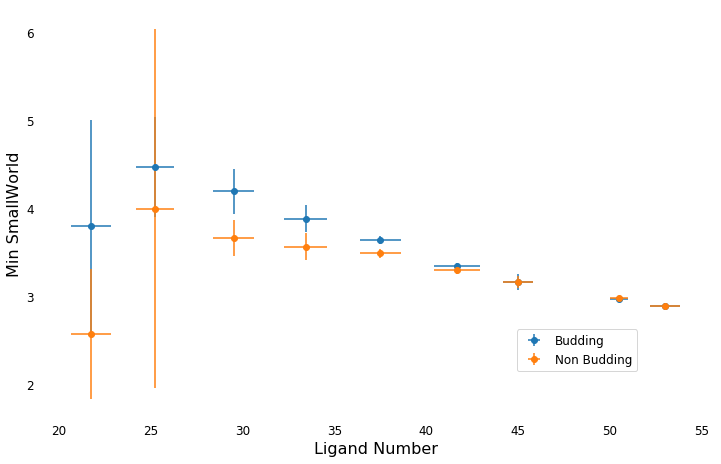

In [157]:
i = 1


fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 4, i)
#     binnedBudC = [budNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
#     binnedBudyErr = [b for b in [np.std(budNets[c][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
#     binnedBudxErr = [b for b in [np.std(budNets["Ligand Number"][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
#     binnedBudC = [b for b in binnedBudC if not np.isnan(b)]
#     binnedNoBudC = [nonbudNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
#     binnedNoBudC = [b for b in binnedNoBudC if not np.isnan(b)]
#     binnedNoBudyErr = [b for b in [np.std(nonbudNets[c][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
#     binnedNoBudxErr = [b for b in [np.std(nonbudNets["Ligand Number"][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    r = buildBinnedPlot(c)
    ax.errorbar(binnedLigandNum,r[0],xerr=r[1],yerr=r[2],fmt='o',label="Budding")
    ax.errorbar(binnedNonBudLigandNum,r[3],yerr=r[5],xerr=r[4],fmt='o',label="Non Budding")
    #ax.plot(binnedLigandNum,binnedBudC,'.',label="Budding")
    plt.ylabel(c)
    plt.xlabel("Ligand Number")
    bigFig(c)
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

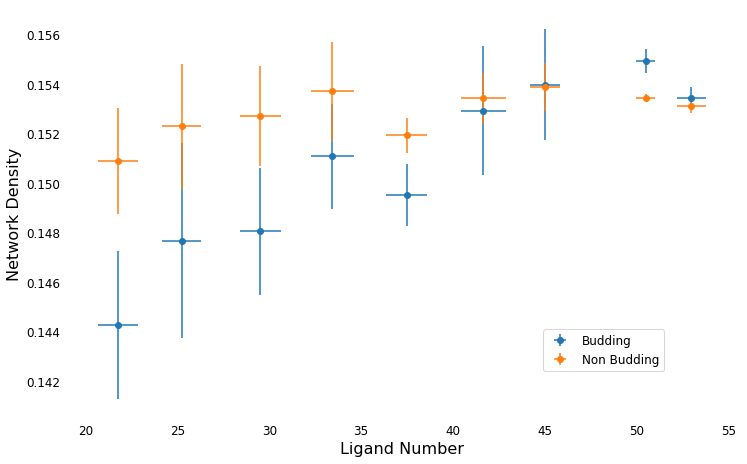

In [156]:
plt.figure(figsize=(12,7.5))
ax = plt.subplot(111)

r = [int(np.floor(min(budNets['Density'])*1000)), int(np.ceil(max(budNets['Density'])*1000)+1)]
# for y in range(r[0],r[1]):    
#     plt.plot(range(r[0],r[1]), [y] * len(range(r[0],r[1])), "--", lw=0.5, color="black", alpha=0.3)

xr = range(int(np.floor(min(budNets['Ligand Number']))-1), int(np.ceil(max(budNets['Ligand Number']))+2))

# for y in range(r[0],r[1]):    
#     plt.plot(xr, [y*0.001] * len(xr) , "--", lw=0.5, color="black", alpha=0.3)    
 
    
r = buildBinnedPlot("Density")

plt.errorbar(binnedLigandNum,r[0],xerr=r[1],yerr=r[2],fmt='o',label="Budding")
plt.errorbar(binnedNonBudLigandNum,r[3],yerr=r[5],xerr=r[4],fmt='o',label="Non Budding")
    
# plt.plot(budNets["Ligand Number"],budNets['Density'],'.',label='_nolegend_',alpha=0.5,color=plt.get_cmap('tab20')(3))
# plt.plot(nonbudNets["Ligand Number"],nonbudNets['Density'],'.',label='_nolegend_',alpha=0.5,color=plt.get_cmap('tab20')(1))
# plt.plot(meanBudNets["Ligand Number"],meanBudNets['Density'],'s',label="Budding",color=plt.get_cmap('tab20')(2))
# plt.plot(meanNonbudNets["Ligand Number"],meanNonbudNets['Density'],'s',label="Non Budding",alpha=0.5,color=plt.get_cmap('tab20')(0))
plt.ylabel("Network Density",fontsize=16)
plt.xlabel("Ligand Number",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
plt.legend(loc='lower right',fontsize=12,bbox_to_anchor=(0.9, 0.1))
plt.savefig('/Users/joel/Projects/Figures/Density-LigandNumber.eps', format='eps', dpi=1000)
plt.savefig('/Users/joel/Projects/Figures/Density-LigandNumber.png')
plt.show()

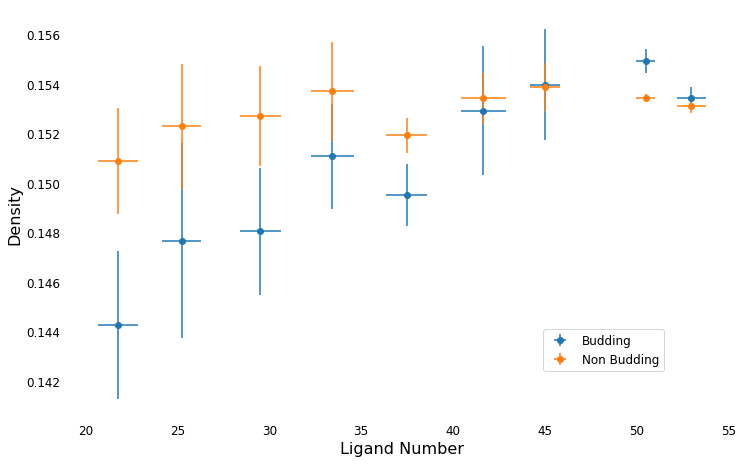

In [146]:
bigFig("Density")

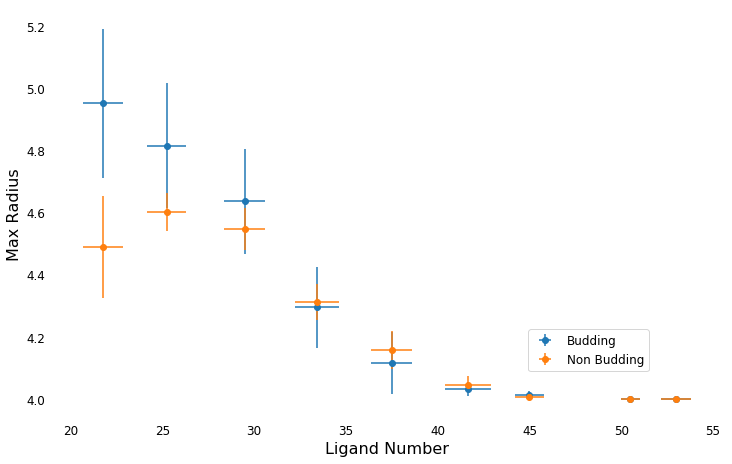

In [147]:
bigFig("Max Radius")

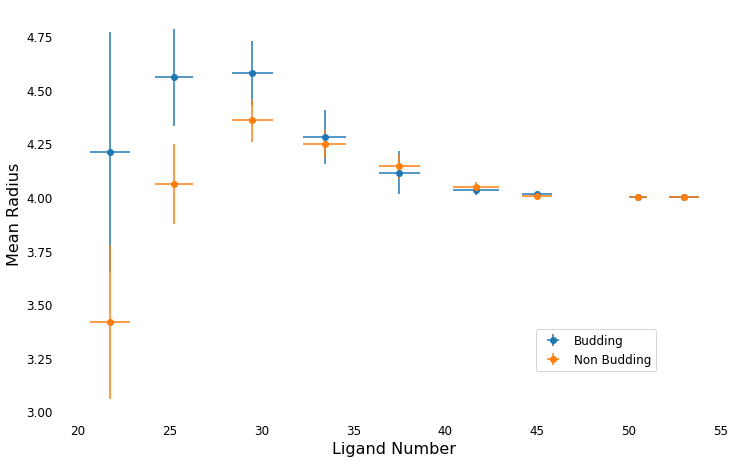

In [148]:
bigFig("Mean Radius")

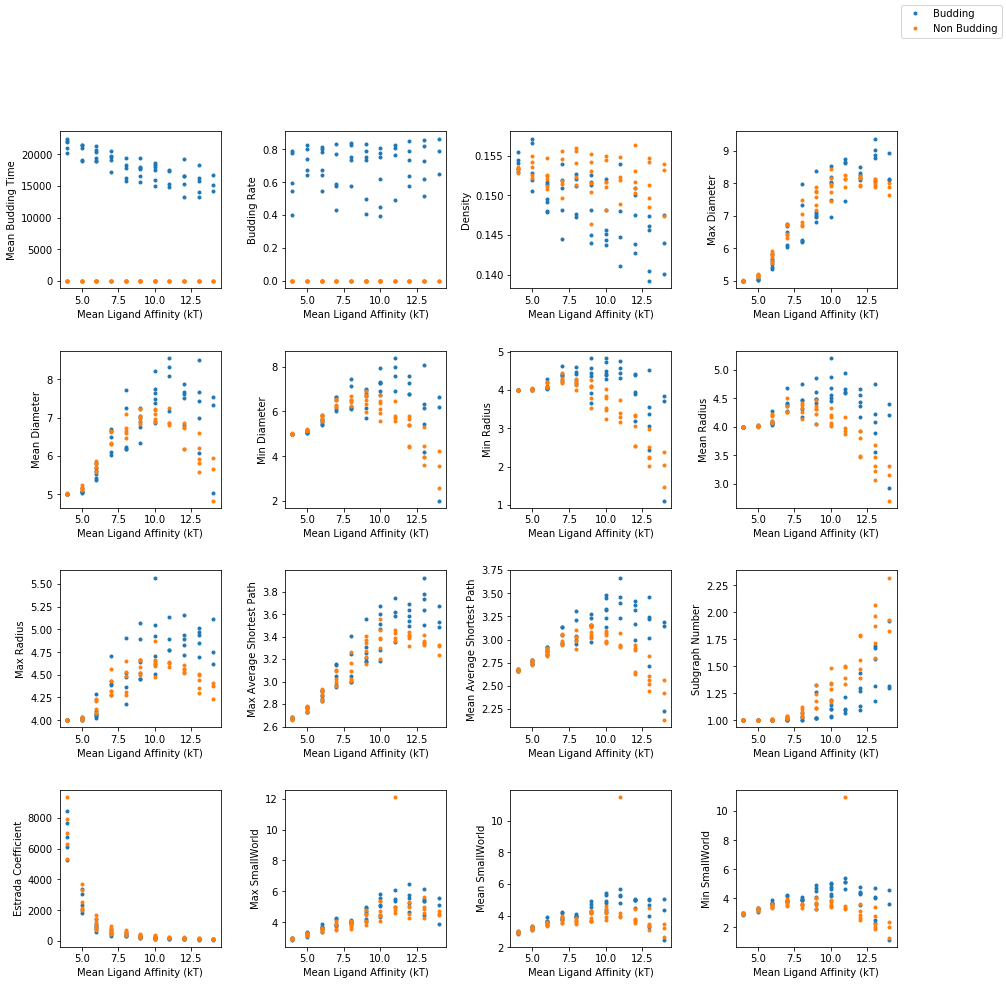

In [14]:
i = 1


fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 4, i)
    ax.plot(budNets['Mean Affinity'],budNets[c],'.',label="Budding")
    ax.plot(nonbudNets['Mean Affinity'],nonbudNets[c],'.',label="Non Budding")
    plt.ylabel(c)
    plt.xlabel("Mean Ligand Affinity (kT)")
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

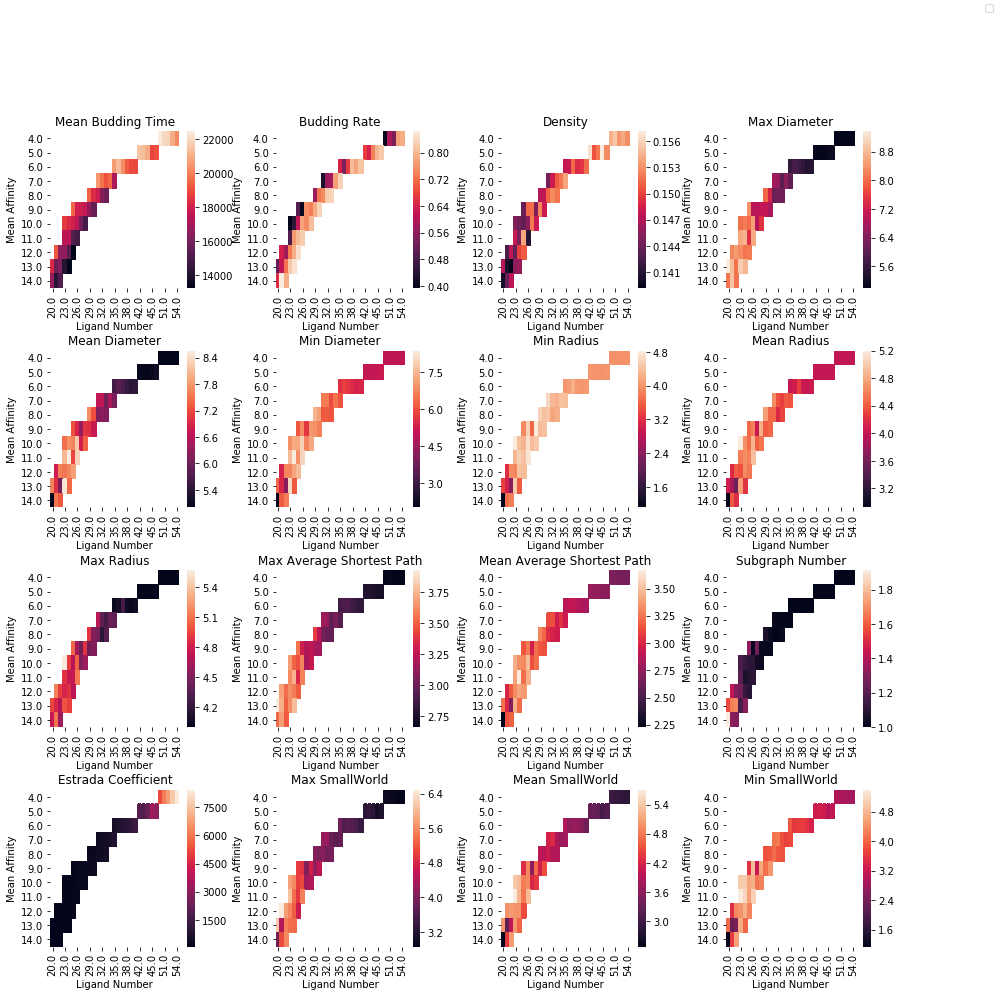

In [15]:
i = 1
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 4, i)
    budNetsT = budNets.pivot("Mean Affinity", "Ligand Number", c)
    ax = sns.heatmap(budNetsT)
    ax.set_title(c)
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

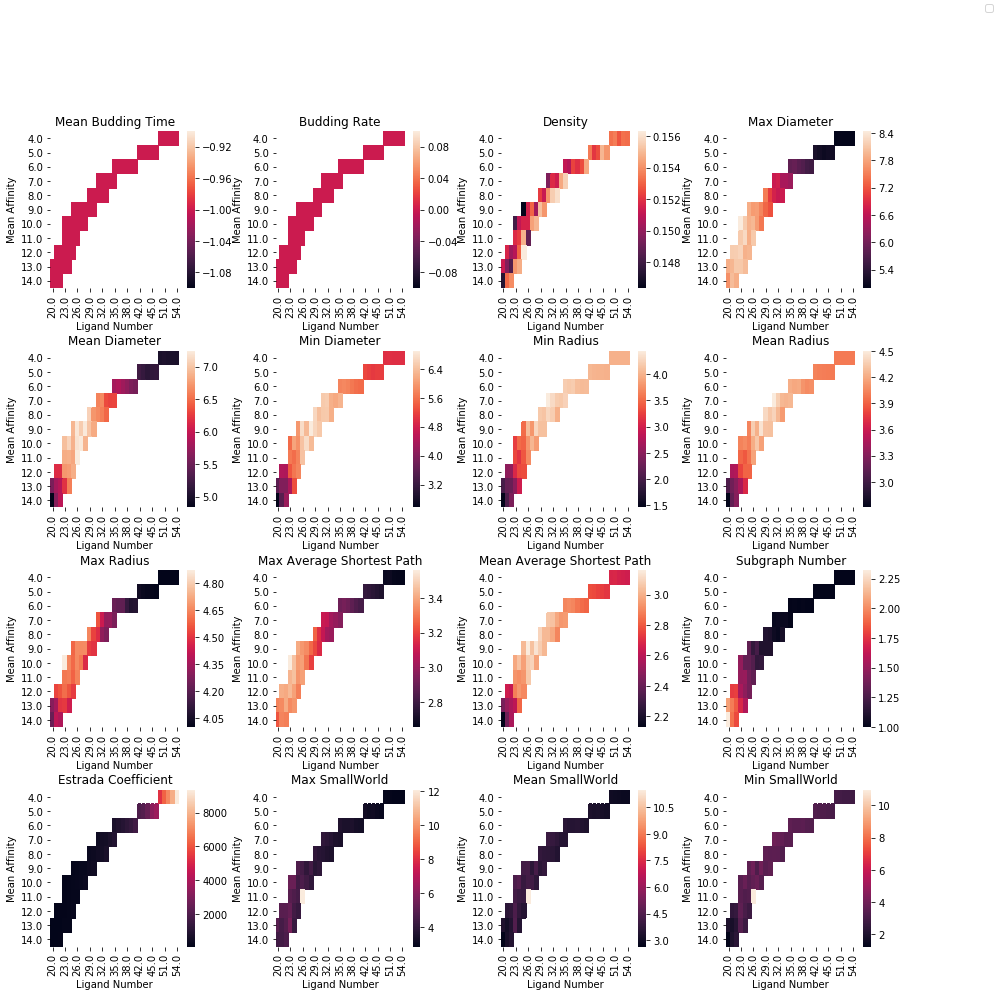

In [16]:
i = 1
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 4, i)
    nonbudNetsT = nonbudNets.pivot("Mean Affinity", "Ligand Number", c)
    ax.set_title(c)
    ax = sns.heatmap(nonbudNetsT)
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

In [109]:
bins = np.linspace(0, 100, 26)
print bins

digitisedLigandNum = np.digitize(meanBudNets["Ligand Number"], bins)
binnedLigandNum = [meanBudNets["Ligand Number"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]
binnedNonBudLigandNum = [meanNonbudNets["Ligand Number"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]
binnedBuddingRate = [meanBudNets["Budding Rate"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]

binnedLigandNum = [b for b in binnedLigandNum if not np.isnan(b)]
binnedNonBudLigandNum = [b for b in binnedNonBudLigandNum if not np.isnan(b)]
binnedBuddingRate = [b for b in binnedBuddingRate if not np.isnan(b)]


[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100.]


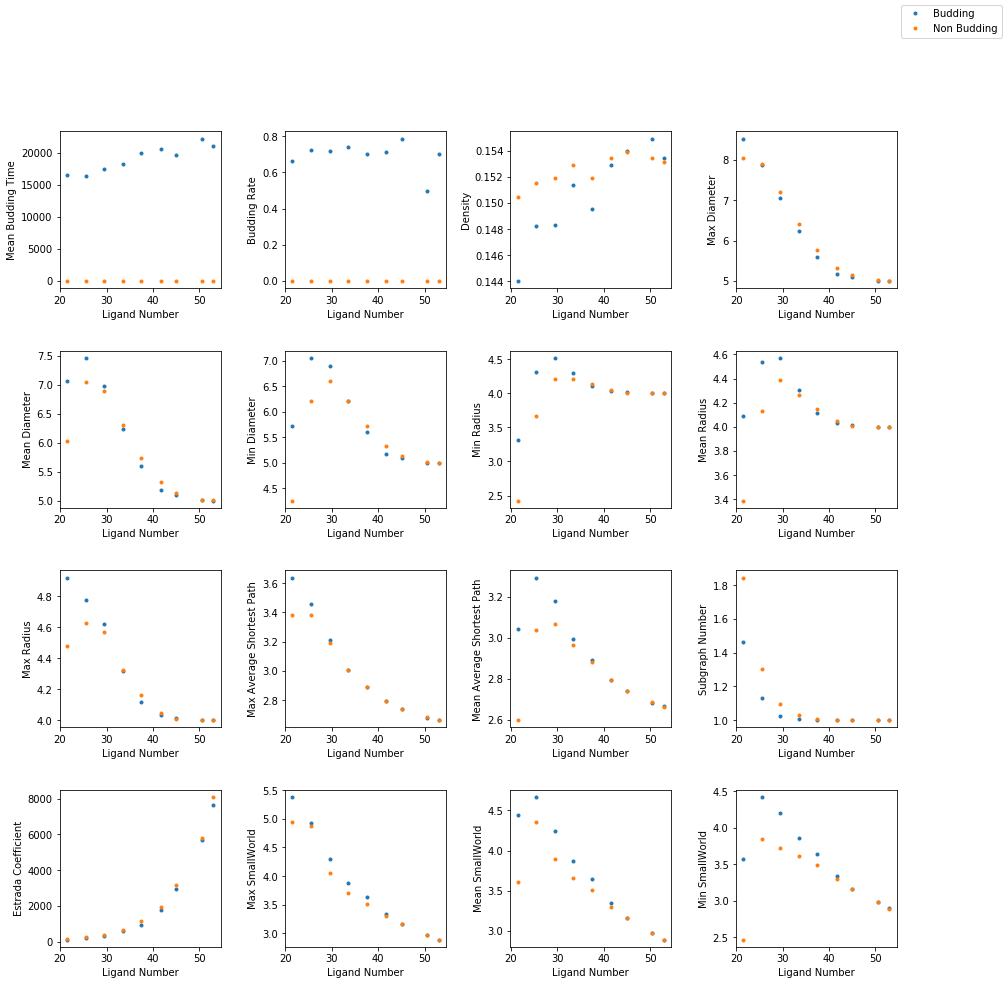

In [110]:
i = 1
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in meanBudNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 4, i)
    binnedBudC = [meanBudNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
    binnedBudC = [b for b in binnedBudC if not np.isnan(b)]
    binnedNoBudC = [meanNonbudNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
    binnedNoBudC = [b for b in binnedNoBudC if not np.isnan(b)]
    ax.plot(binnedLigandNum,binnedBudC,'.',label="Budding")
    ax.plot(binnedNonBudLigandNum,binnedNoBudC,'.',label="Non Budding")
    plt.ylabel(c)
    plt.xlabel("Ligand Number")
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

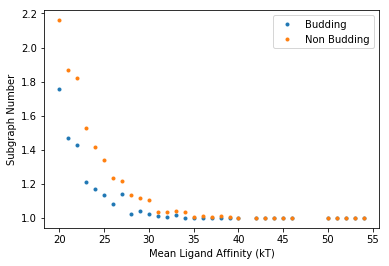

In [20]:
c = 'Subgraph Number'
plt.plot(meanBudNets['Ligand Number'],meanBudNets[c],'.',label="Budding")
plt.plot(meanNonbudNets['Ligand Number'],meanNonbudNets[c],'.',label="Non Budding")
plt.ylabel(c)
plt.xlabel("Mean Ligand Affinity (kT)")
plt.legend()
plt.show()

In [21]:
budNets = criticalNets[criticalNets['Mean Budding Time'] > 0.0].groupby(['Mean Affinity']).mean().reset_index()
nonbudNets = criticalNets[criticalNets['Mean Budding Time'] < 0.0].groupby(['Mean Affinity']).mean().reset_index()

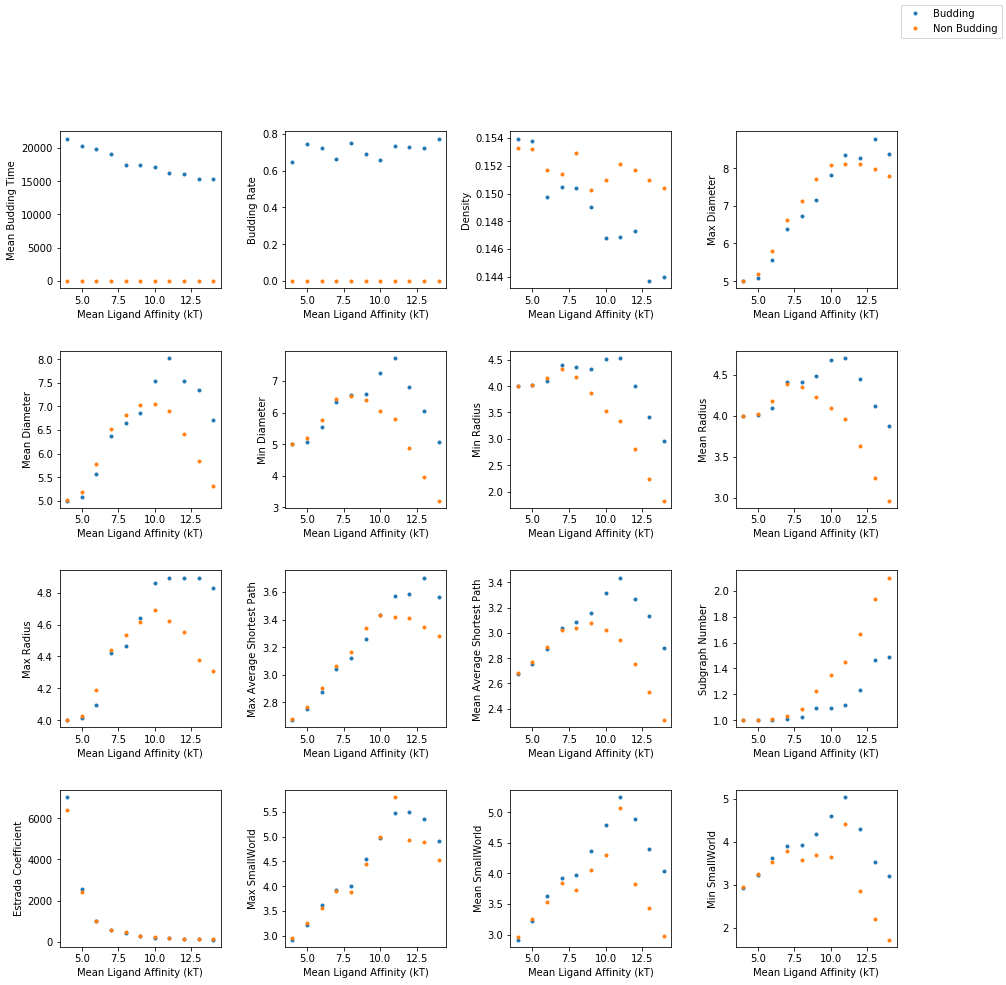

In [22]:
i = 1


fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 4, i)
    ax.plot(budNets['Mean Affinity'],budNets[c],'.',label="Budding")
    ax.plot(nonbudNets['Mean Affinity'],nonbudNets[c],'.',label="Non Budding")
    plt.ylabel(c)
    plt.xlabel("Mean Ligand Affinity (kT)")
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

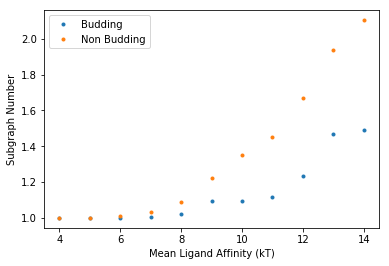

In [23]:
c = 'Subgraph Number'
plt.plot(budNets['Mean Affinity'],budNets[c],'.',label="Budding")
plt.plot(nonbudNets['Mean Affinity'],nonbudNets[c],'.',label="Non Budding")
plt.ylabel(c)
plt.xlabel("Mean Ligand Affinity (kT)")
plt.legend()
plt.show()

In [24]:
zoo_df = pd.read_csv('/Users/joel/Projects/golden/zoo.csv',names=['name','n','e','fitness','bud_rate','budtime'])

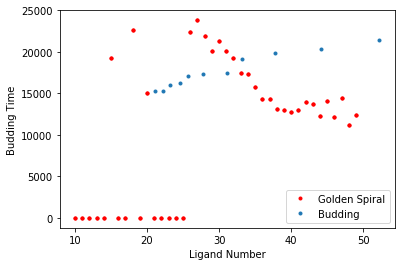

In [25]:
plt.plot(zoo_df['n'],zoo_df['budtime'],'.',label="Golden Spiral",color="red")
plt.plot(budNets['Ligand Number'],budNets['Mean Budding Time'],'.',label="Budding")
plt.ylabel('Budding Time')
plt.xlabel("Ligand Number")
plt.legend()
plt.show()

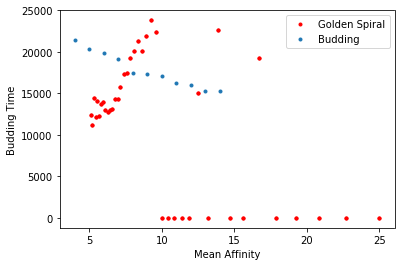

In [26]:
plt.plot(zoo_df['e'],zoo_df['budtime'],'.',label="Golden Spiral",color="red")
plt.plot(budNets['Mean Affinity'],budNets['Mean Budding Time'],'.',label="Budding")
plt.ylabel('Budding Time')
plt.xlabel("Mean Affinity")
plt.legend()
plt.show()

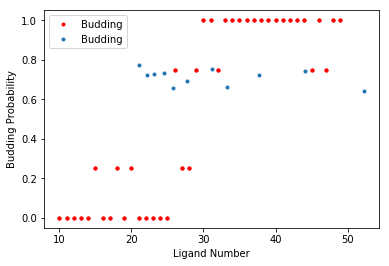

In [27]:
plt.plot(zoo_df['n'],zoo_df['bud_rate'],'.',label="Budding",color="red")
plt.plot(budNets['Ligand Number'],budNets['Budding Rate'],'.',label="Budding")
plt.ylabel('Budding Probability')
plt.xlabel("Ligand Number")
plt.legend()
plt.show()

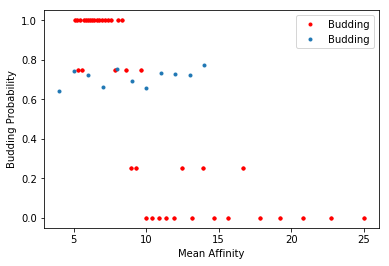

In [28]:
plt.plot(zoo_df['e'],zoo_df['bud_rate'],'.',label="Budding",color="red")
plt.plot(budNets['Mean Affinity'],budNets['Budding Rate'],'.',label="Budding")
plt.ylabel('Budding Probability')
plt.xlabel("Mean Affinity")
plt.legend()
plt.show()

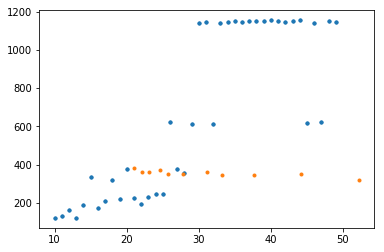

In [29]:
plt.plot(zoo_df['n'],zoo_df['fitness'],'.',label="Budding")
plt.plot(budNets['Ligand Number'],budNets['Fitness'],'.',label="Budding")